In [1]:
import pandas as pd
import os
import librosa
import pickle
import librosa
import numpy as np

from sklearn.metrics import f1_score,precision_score,recall_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_serialized_file(file_path):
#   directory = '/kaggle/working/' + file_path # Change 'directory' Accordingly
  directory = file_path 
  infile = open(directory,'rb')
  loaded_data = pickle.load(infile)
  infile.close()
  return loaded_data

In [3]:
def generate_mel_spec(audio):
  mel = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128, n_fft=2048, hop_length=512))
  return mel

def generate_mfcc(audio):
  mfcc = librosa.feature.mfcc(y=audio, n_mfcc=128, n_fft=2048, hop_length=512)
  return mfcc

def generate_chroma(audio):
  chroma = librosa.feature.chroma_stft(y=audio, sr=22050, n_chroma=128, n_fft=2048, hop_length=512)
  return chroma

In [4]:
def create_features():
  labelled_features = []

#   audio_array = read_serialized_file("label_enc_audio_aug.pkl")
#   audio_array = read_serialized_file("/kaggle/input/healthy-and-abnormal-lung-sounds/label_enc_audio_binary_norm.pkl")
  audio_array = read_serialized_file("/kaggle/input/2026-binary-audio/label_enc_audio_binary_2026_norm.pkl")

  for raw_audio, label,file in audio_array:
    melsp = generate_mel_spec(raw_audio)
    mfcc = generate_mfcc(raw_audio)
    chroma = generate_chroma(raw_audio)

    three_chanel = np.stack((melsp, mfcc, chroma), axis=2)

    labelled_features.append([three_chanel, label, file])

  print(len(labelled_features))

  return labelled_features

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def get_classification_result(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_0_accuracy = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    class_1_accuracy = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    
    print(f"Class 0 Accuracy: {class_0_accuracy:.4f}")
    print(f"Class 1 Accuracy: {class_1_accuracy:.4f}")
    print()
    
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

In [6]:
stacked_labeled_features = create_features()

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


2026


In [7]:
# stacked_features_path = '/kaggle/working/stacked_specs_binary_norm.pkl'
stacked_features_path = '/kaggle/working/stacked_specs_binary_norm_2026.pkl'

with open(stacked_features_path, "wb") as file:
    pickle.dump(stacked_labeled_features, file)

In [8]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,  BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD

from keras import callbacks
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, max_epochs=80):  # Add max_epochs as a parameter
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch[:max_epochs], history.history[metric][:max_epochs], color=colors[0], label='Train')  # Limit the data to the first 80 epochs
    plt.plot(history.epoch[:max_epochs], history.history['val_'+metric][:max_epochs],
             color='orange', label='Val')  # Limit the data to the first 80 epochs
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      ylim_max = 1.05  # Adjust the padding value as needed
      plt.ylim([0, ylim_max])
      y_ticks = np.arange(0, ylim_max, 0.2)  # Define y-axis ticks with 0.1 increments
      plt.yticks(y_ticks)
    plt.grid(linestyle='--', linewidth=0.5, color='gray')
    plt.legend()

In [10]:
stacked_spects = read_serialized_file("/kaggle/working/stacked_specs_binary_norm_2026.pkl")
feature_data = pd.DataFrame(stacked_spects,columns=['feature','class','file'])

In [11]:
# files_to_remove = [980,1181,1186,1353,1393,1413,1776,1786]
# mask = feature_data['file'].isin(files_to_remove)
# feature_data_filtered = feature_data[~mask]

In [12]:
X = np.array(feature_data['feature'].tolist())
y = np.array(feature_data['class'].tolist())
f = np.array(feature_data['file'].tolist())

In [13]:
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

X_test, X_validate, y_test, y_validate = train_test_split(X_,y_,test_size=0.5,random_state=42, stratify=y_)

In [14]:
X_train_f, X_f, y_train_f, y_f = train_test_split(f,y,test_size=0.2,random_state=42, stratify=y)

X_test_f, X_validate_f, y_test_f, y_validate_f = train_test_split(X_f,y_f,test_size=0.5,random_state=42, stratify=y_f)

In [15]:
if 1 in X_train_f:
    print ("Hey")

Hey


In [16]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_validate))

(1620, 128, 264, 3)
(203, 128, 264, 3)
(203, 128, 264, 3)


In [17]:
print(np.shape(X_train_f))
print(np.shape(X_test_f))
print(np.shape(X_validate_f))

(1620,)
(203,)
(203,)


In [18]:
input_shape = (128, 264, 3)

In [19]:
train_values = [np.count_nonzero(y_train == i) for i in np.unique(y_train)]
print(train_values)

[780, 840]


In [20]:
print(y_train)

[0 1 1 ... 1 1 0]


In [24]:
disease_stats = [780, 840]
min_value = min(disease_stats)

weights = [min_value / value for value in disease_stats]
class_weights = {label: weight for label, weight in enumerate(weights)}
sample_weight=np.array([class_weights[label] for label in y_train])

In [25]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 264, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
#     model.add(Conv2D(256, (3, 3),padding='same', activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
model = create_model()
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 8, restore_best_weights = True, verbose=1)
baseline_history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_validate, y_validate), callbacks =[earlystopping], sample_weight=sample_weight)

Epoch 1/100
51/51 [==============================] - 4s 28ms/step - loss: 1.2511 - accuracy: 0.5593 - val_loss: 0.5674 - val_accuracy: 0.6847
Epoch 2/100
51/51 [==============================] - 1s 20ms/step - loss: 0.6396 - accuracy: 0.6469 - val_loss: 0.6546 - val_accuracy: 0.6946
Epoch 3/100
51/51 [==============================] - 1s 21ms/step - loss: 0.5954 - accuracy: 0.6741 - val_loss: 0.6163 - val_accuracy: 0.6798
Epoch 4/100
51/51 [==============================] - 1s 21ms/step - loss: 0.5472 - accuracy: 0.7105 - val_loss: 0.5316 - val_accuracy: 0.6946
Epoch 5/100
51/51 [==============================] - 1s 20ms/step - loss: 0.5210 - accuracy: 0.7278 - val_loss: 0.4697 - val_accuracy: 0.7882
Epoch 6/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4819 - accuracy: 0.7611 - val_loss: 0.4562 - val_accuracy: 0.7586
Epoch 7/100
51/51 [==============================] - 1s 20ms/step - loss: 0.4759 - accuracy: 0.7605 - val_loss: 0.4386 - val_accuracy: 0.7833
Epoch 

In [29]:
model.save('/kaggle/working/binary_model_v1.h5')
import joblib
model_path = '/kaggle/working/binary_model_v1.joblib'
joblib.dump(model, model_path)

pkl_model_path = '/kaggle/working/binary_model_v1.pkl'

with open(pkl_model_path, "wb") as file:
    pickle.dump(pkl_model_path, file)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# baseline_history
# baseline_history.save('/kaggle/working/baseline_history_v1.h5')
import joblib
base_path = '/kaggle/working/binary_baseline_v1.joblib'
joblib.dump(baseline_history, base_path)

pkl_base_path = '/kaggle/working/binary_baseline_v1.pkl'

with open(pkl_model_path, "wb") as file:
    pickle.dump(baseline_history, file)

In [32]:
pkl_base_path = '/kaggle/working/binary_baseline_v1.pkl'

with open(pkl_model_path, "wb") as file:
    pickle.dump(baseline_history, file)

In [27]:
get_classification_result(model, X_test, y_test)

7/7 [==============================] - 0s 7ms/step
Overall Accuracy: 0.9409
Class 0 Accuracy: 0.9278
Class 1 Accuracy: 0.9528

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        97
           1       0.94      0.95      0.94       106

    accuracy                           0.94       203
   macro avg       0.94      0.94      0.94       203
weighted avg       0.94      0.94      0.94       203



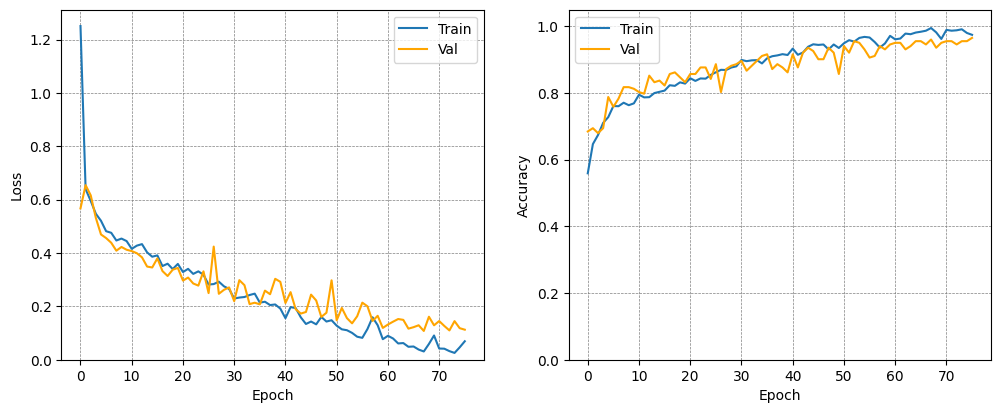

In [28]:
plot_metrics(baseline_history, 150)

7/7 [==============================] - 0s 7ms/step


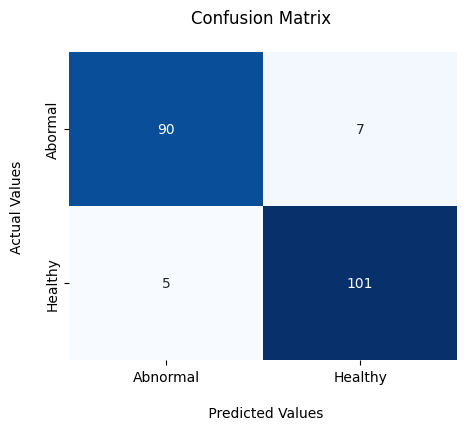

In [42]:
from sklearn import metrics
pred = model.predict(X_test)

predicted = np.argmax(pred, axis=1)
y_pred_binary = (pred >= 0.5).astype(int)

# confusion_matrix = metrics.confusion_matrix(y_test, predicted)
conf_matrix = confusion_matrix(y_test, y_pred_binary)


plt.figure(figsize=(5,4))
fx=sns.heatmap(conf_matrix,fmt="d", annot=True,cmap="Blues", cbar=False, 
            xticklabels=["Abnormal", "Healthy"], yticklabels=["Abormal", "Healthy"])

fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
plt.show()

In [22]:
print(y_test)

[0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0
 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1
 0 1 1 0 1 1 0 0]


In [23]:
preds = []
for i in range(len(X_test)):
    r = model.predict(np.array([X_test[i]]), batch_size=1)
    binary_output = (r > 0.5).astype(int)
    preds.append(binary_output[0])

1/1 [==============================] - 0s 17ms/step


In [24]:
print(accuracy_score(y_test, preds))

0.5077720207253886


#### plot_metrics(baseline_history, 100)

In [23]:
preds = model.predict(X_test)

NameError: name 'model' is not defined

In [74]:
pred = model.predict(x_test)

1/1 [==============================] - 0s 19ms/step


In [26]:
import joblib
loaded_model = joblib.load('/kaggle/input/jolib-model/binary_model.joblib')
# joblib.dump(model, '/kaggle/working/binary_model.joblib')

In [36]:
loaded_model.save('/kaggle/working/binary_model.keras')

In [31]:
pred = loaded_model.predict(X_test)
# preds = (pred > 0.5).astype(int)
print(pred)

7/7 [==============================] - 0s 6ms/step
[[7.77769566e-01]
 [3.27856094e-03]
 [7.04529822e-01]
 [9.74894106e-01]
 [9.81335163e-01]
 [2.51961290e-04]
 [9.31020439e-01]
 [9.97478545e-01]
 [9.95615005e-01]
 [9.77744520e-01]
 [6.21611325e-05]
 [9.81652915e-01]
 [9.82822359e-01]
 [9.61136460e-01]
 [4.92380977e-01]
 [6.34923577e-01]
 [2.00054884e-09]
 [9.36461091e-01]
 [2.38935836e-02]
 [9.76376176e-01]
 [2.58313389e-06]
 [9.51632619e-01]
 [3.24843836e-06]
 [2.90956954e-03]
 [1.23391040e-02]
 [9.78000760e-01]
 [1.25050300e-03]
 [7.09936261e-01]
 [9.86968815e-01]
 [1.77578499e-06]
 [9.91916358e-01]
 [2.85344953e-07]
 [9.50130045e-01]
 [2.27016285e-02]
 [6.19983487e-03]
 [6.31179750e-01]
 [5.88612212e-03]
 [9.94332671e-01]
 [1.85669160e-05]
 [4.29549860e-03]
 [1.29916373e-07]
 [1.61076561e-01]
 [9.96738821e-02]
 [6.93039283e-06]
 [8.26753821e-05]
 [1.99094370e-01]
 [1.66775018e-04]
 [2.60780334e-01]
 [8.66239774e-04]
 [9.99466002e-01]
 [9.69074667e-01]
 [9.96207714e-01]
 [1.99070293e

In [27]:
preds_single=[]
for i in range(len(y_test)):
    single_sample = np.array([X_test[i]])
    y_pred_prob = loaded_model.predict(single_sample, batch_size = 1)
    y_pred_single = (y_pred_prob > 0.5).astype(int)
    preds_single.append(y_pred_single[0].tolist())

1/1 [==============================] - 0s 16ms/step


In [31]:
print(y_test_f)

[0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0
 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1
 0 1 1 0 1 1 0 0]


In [25]:
print(X_test[0])

[[[ 3.89305344e+01 -9.42005463e+01  7.84507632e-01]
  [ 4.06496620e+01 -1.47866516e+02  8.15934777e-01]
  [ 3.46554260e+01 -2.30926727e+02  9.97674048e-01]
  ...
  [ 4.18731766e+01 -2.35283997e+02  8.26162219e-01]
  [ 3.98133774e+01 -2.36058685e+02  8.37304592e-01]
  [ 3.90725670e+01 -2.37061432e+02  7.36119568e-01]]

 [[ 3.16422844e+01  1.17960480e+02  7.87731469e-01]
  [ 3.28831749e+01  1.06637375e+02  8.19378853e-01]
  [ 2.55817528e+01  4.41539459e+01  9.94987607e-01]
  ...
  [ 3.43413849e+01  3.85755310e+01  8.31218421e-01]
  [ 2.76876812e+01  3.74727859e+01  8.44966233e-01]
  [ 2.63107395e+01  3.60665588e+01  7.46123672e-01]]

 [[ 2.01228943e+01  1.39983063e+01  7.90391803e-01]
  [ 2.00486908e+01  2.98532448e+01  8.22088897e-01]
  [ 1.60271435e+01  4.18233795e+01  9.91287768e-01]
  ...
  [ 2.16075897e+01  3.78916321e+01  8.36241961e-01]
  [ 2.19031696e+01  3.67678375e+01  8.52019966e-01]
  [ 1.64681206e+01  3.53969650e+01  7.55882919e-01]]

 ...

 [[-2.29725914e+01 -2.74123192e-01

In [29]:
print(X_test_f)

[ 490  613 1273 1758 1842  161 1117 1623 1121 1307  188 1766 1327 1899
  874 1237  436 1587  727 1089  493 1671  241  167  858 1141  720  662
 1848  129 1553  243   36  386  734  777  795 1389  467  876  503  687
 1666  367  346   53  578  702  828 1878 1922 1443  218 1902 1023  135
 1881  806  986    2  414   33  726  477  989 1760  968   15  242  728
  419  999  682  563 1707  460 1885 1267  201  813  816 1791  344  822
  562  861 1891  839 1828 1296 1579 1203  556 1664 1736 1582   21 1569
 1635  215 1654  525  749 1597 1248 1768 1555 1616 1819 1631  991 1856
 1650 1312 1804 1302   86  615  316 1868 1275 1627 1562   88  561  575
 1384  331  461  863  647 1390 1618  202  857 1018 1440  472  373   65
 1270 1015 1850 1672 1133 1005  541  157 1775  675 1812  701  106 1800
  987 1494 1135 1280 1780 1381  521 1604  805  428 1796  107  289 1513
 1834  700 1071  139  981  131  748   99 1531  703   59   35 1232 1429
  190 1923 1355  379 1386 1082  827 1459 1641  340  921]


In [43]:
xc = loaded_model.predict(np.array([X_test[4]]), batch_size = 1)
print(xc)

1/1 [==============================] - 0s 18ms/step
[[0.9432588]]


In [30]:
print(preds_single)

[[0], [0], [0], [0], [1], [0], [0], [1], [1], [0], [0], [1], [1], [1], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0], [0], [1], [1], [0], [1], [0], [0], [1], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [1], [0], [0], [1], [1], [0], [0], [0], [0], [0], [1], [1], [0], [0], [1], [1], [0], [0], [0], [0], [1], [1], [0], [0], [1], [0], [0], [0], [1], [0], [1], [1], [1], [1], [1], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0]]


In [ ]:
get_classification_result(loaded_model, X_test, y_test)

In [32]:
print(accuracy_score(y_test,preds))
print(accuracy_score(y_test,preds_single))

0.9015544041450777
0.7253886010362695


In [ ]:
loaded_model_2 = tf.keras.models.load_model('/kaggle/working/binary_model')

In [ ]:
y_pred_prob = loaded_model_2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
import shutil

# Replace 'model' with your directory name
shutil.make_archive("/kaggle/working/model", 'zip', "/kaggle/working/model")